In [1]:
from sklearn.linear_model import LogisticRegression, LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from llr import compute_llr
from sim import gen_fuzzy_rdd, point_plot
from tree import RDDTree

import statsmodels.discrete.discrete_model as smd

%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Simulated fuzzy RDD

- true discontinuity at x = 0.5

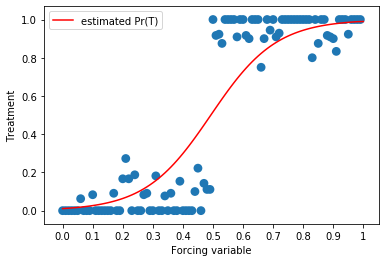

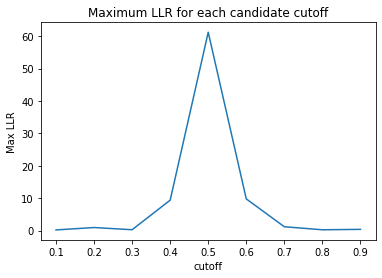

In [3]:
# generate some data
n = 1000
df = gen_fuzzy_rdd(n, 0.8, 0.8, 0.2, seed=0)

# fit background function
lr = LogisticRegression(random_state=0)
X = df['x'].values.reshape(-1, 1)
lr.fit(X, df['t'])

test_X = np.linspace(0,1,100).reshape(-1, 1)
preds = lr.predict_proba(test_X)[:, 1]

#plot the RDD and the background function
scale=100
point_plot('x', 't', df, scale, errwidth=0)
plt.xlabel("Forcing variable")
plt.ylabel("Treatment")
disp_X = np.floor(test_X.flatten()*scale)
sns.lineplot(disp_X, preds, color='red', label="estimated Pr(T)")
plt.legend()
plt.show()

# check LLR computation
all_Ps = lr.predict_proba(X)[:, 1]
all_Ts = df['t']
cutoffs = np.arange(0.1, 1, 0.1)

llrs = []
for cutoff in cutoffs:
    Gs = (X > cutoff).astype(int).flatten()
    llr = compute_llr(all_Ps, all_Ts, Gs)
    llrs.append(llr)

plt.plot(cutoffs, llrs)
plt.title("Maximum LLR for each candidate cutoff")
plt.ylabel("Max LLR")
plt.xlabel("cutoff")
#plt.axhline(y=uncorr_thres, ls='--', color='green', label="95% threshold")
#plt.axhline(y=corr_thres, ls='--', color='red', label="Bonferroni 95% threshold")
#plt.legend()
plt.show()

#%% test tree implementation

df['Ts'] = all_Ts
df['Ps'] = all_Ps

In [4]:
%%time
tree = RDDTree(df = df[['x', 'Ts', 'Ps']], 
               max_depth = 2, 
               min_size = 2, 
               threshold = 5)
tree.build_tree()

candidate column: x


/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


split at level 0
candidate column: x
split at level 1
candidate column: x
split at level 2
candidate column: x
split at level 2
candidate column: x
split at level 1
candidate column: x
split at level 2
candidate column: x
split at level 2
CPU times: user 1min 17s, sys: 32.1 ms, total: 1min 17s
Wall time: 1min 17s


In [5]:
print(tree.root)

Split col: x, val: 0.498, llr: 62.567915402903004


# Real data: Herlands test_score_2012

In [6]:
test_score_df = pd.read_csv("/home/tliu/automatic-rdd-discovery/data/test_score_2012/RDD_Guide_Dataset_0.csv")

In [7]:
test_score_df['Ts'] = test_score_df['treat']
test_score_df = test_score_df.drop(['cutoff', 'posttest', 'ID', 'treat'], axis='columns')
print(test_score_df.shape)
test_score_df = test_score_df.dropna()
print(test_score_df.shape)

(2767, 11)
(2606, 11)


## Sk-learn logistic regression implementation

### Notes

- two continuous variables: pretest and age
- this is a sharp discontinuity, with true cutoff at pretest = 215
- the sklearn model has to be *way* underfit in order to have reasonable residuals
    - LLR is thus highly sensitive to the fit of the background function, sometimes even falsely finding a discontinuity in age as the best split if the fit is "too good"
    - There's no good metric for what the background function should look like -> major downfall of this approach
- in sharp RDD cases, what is the point of RDD discovery?
    - in this test score data, the logistic regression **with default hyperparameters** finds the discontinuity without having to run the LLR procedure

### example 1: LR no penalty, 40 iterations

In [8]:
iterations = 40
lr = LogisticRegression(random_state=0, max_iter=iterations, penalty='none')
X = test_score_df.drop('Ts', axis='columns')
lr.fit(X[['pretest', 'age']], test_score_df['Ts'])

/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=40,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
test_score_df['Ps'] = lr.predict_proba(X[['pretest', 'age']])[:, 1]

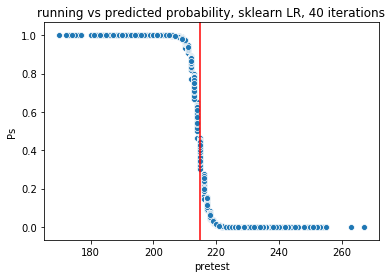

In [10]:
sns.scatterplot(x=X['pretest'], y=test_score_df['Ps'])
plt.axvline(x=215, label="true discontinuity", color='red')
plt.title("running vs predicted probability, sklearn LR, {} iterations".format(iterations));

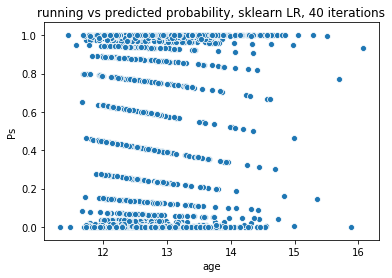

In [11]:
sns.scatterplot(x=X['age'], y=test_score_df['Ps'])
#plt.axvline(x=215, label="true discontinuity", color='red')
plt.title("running vs predicted probability, sklearn LR, {} iterations".format(iterations));

#### Fitting tree

In [12]:
%%time
tree = RDDTree(df = test_score_df[['pretest', 'Ps', 'Ts']], 
               max_depth = 3, 
               min_size = 2, 
               threshold = -1)
tree.build_tree()

candidate column: pretest


/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


split at level 0
candidate column: pretest


/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


split at level 1
candidate column: pretest
split at level 2
candidate column: pretest
split at level 2
candidate column: pretest


/home/tliu/rdd-discovery/utils/llr.py:57: RuntimeWarning: invalid value encountered in true_divide
  - np.log(epsilon + 1 - Ps + (mus * Ps))


split at level 1
CPU times: user 23.6 s, sys: 4 µs, total: 23.6 s
Wall time: 23.6 s


In [13]:
print("Root: " + str(tree.root))
print("\tLeft: " + str(tree.root.left))
print("\t\tLeft: " + str(tree.root.left.left))
print("\t\tRight: " + str(tree.root.left.right))
print("\tRight: " + str(tree.root.right))

Root: Split col: pretest, val: 220, llr: 0.011571750779860057
	Left: Split col: pretest, val: 214, llr: 183.43132824627216
		Left: Terminal data shape: (1214, 3)
		Right: Terminal data shape: (497, 3)
	Right: Terminal data shape: (895, 3)


### example 1: LR no penalty, 45 iterations

In [14]:
iterations = 45
lr = LogisticRegression(random_state=0, max_iter=iterations, penalty='none')
X = test_score_df.drop('Ts', axis='columns')
lr.fit(X[['pretest', 'age']], test_score_df['Ts'])

/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=45,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
test_score_df['Ps'] = lr.predict_proba(X[['pretest', 'age']])[:, 1]

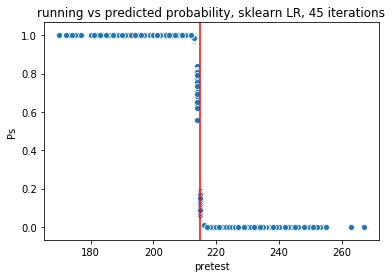

In [16]:
sns.scatterplot(x=X['pretest'], y=test_score_df['Ps'])
plt.axvline(x=215, label="true discontinuity", color='red')
plt.title("running vs predicted probability, sklearn LR, {} iterations".format(iterations));

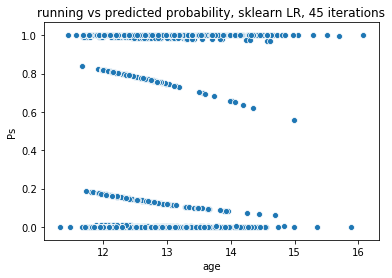

In [17]:
sns.scatterplot(x=X['age'], y=test_score_df['Ps'])
#plt.axvline(x=215, label="true discontinuity", color='red')
plt.title("running vs predicted probability, sklearn LR, {} iterations".format(iterations));

#### Fitting tree

In [18]:
%%time
tree = RDDTree(df = test_score_df[['pretest', 'Ps', 'Ts']], 
               max_depth = 3, 
               min_size = 2, 
               threshold = -1)
tree.build_tree()

candidate column: pretest


/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


split at level 0
candidate column: pretest
split at level 1
candidate column: pretest


/home/tliu/rdd-discovery/utils/llr.py:57: RuntimeWarning: invalid value encountered in true_divide
  - np.log(epsilon + 1 - Ps + (mus * Ps))
/home/tliu/.conda/envs/rdd/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


split at level 1
candidate column: pretest
split at level 2
candidate column: pretest
split at level 2
candidate column: pretest
split at level 3
candidate column: pretest
split at level 3
CPU times: user 22.4 s, sys: 7.98 ms, total: 22.4 s
Wall time: 22.5 s


In [19]:
print("Root: " + str(tree.root))
print("\tLeft: " + str(tree.root.left))
print("\t\tLeft: " + str(tree.root.left.left))
print("\t\tRight: " + str(tree.root.left.right))

Root: Split col: pretest, val: 180, llr: 1.5230546127473095
	Left: Terminal data shape: (9, 3)
		Left: None
		Right: None


## Herlands background function implementation

In [20]:
y = test_score_df['Ts']
x_in = X[['age','pretest', 'gender']]
fx = smd.Logit(endog=np.array(y), exog=np.array(x_in)).fit()
fitted_vals = fx.predict(x_in)

Optimization terminated successfully.
         Current function value: 0.411457
         Iterations 7


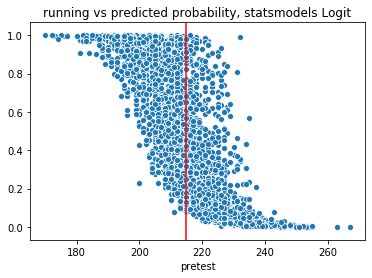

In [21]:
sns.scatterplot(x=X['pretest'], y=fitted_vals)
#sns.scatterplot(x=X['age'], y=fitted_vals)
plt.axvline(x=215, label="true discontinuity", color='red')
plt.title("running vs predicted probability, statsmodels Logit");

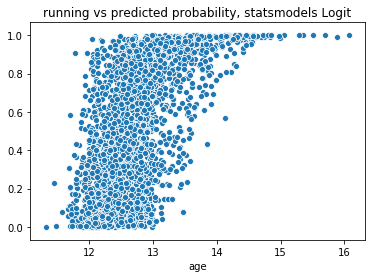

In [22]:
sns.scatterplot(x=X['age'], y=fitted_vals)
plt.title("running vs predicted probability, statsmodels Logit");

### Fitting tree

In [23]:
test_score_df['Ps'] = fitted_vals

In [24]:
%%time
tree = RDDTree(df = test_score_df[['pretest', 'Ps', 'Ts']], 
               max_depth = 3, 
               min_size = 2, 
               threshold = -1)
tree.build_tree()

candidate column: pretest
split at level 0
candidate column: pretest
split at level 1
candidate column: pretest
split at level 2
candidate column: pretest
split at level 2
candidate column: pretest
split at level 1
CPU times: user 19.8 s, sys: 3.99 ms, total: 19.8 s
Wall time: 19.8 s


In [25]:
print("Root: " + str(tree.root))
print("\tLeft: " + str(tree.root.left))
print("\t\tLeft: " + str(tree.root.left.left))
print("\t\tRight: " + str(tree.root.left.right))
print("\tRight: " + str(tree.root.right))

Root: Split col: pretest, val: 218, llr: 28.430237103585775
	Left: Split col: pretest, val: 214, llr: 705.3335111106948
		Left: Terminal data shape: (1214, 3)
		Right: Terminal data shape: (346, 3)
	Right: Terminal data shape: (1046, 3)


# Real data: ED usage

In [26]:
ed_df = pd.read_csv("/home/tliu/automatic-rdd-discovery/data/ED_visits/P03_ED_Analysis_File.csv")

In [27]:
ed_df['Ts'] = ed_df['self_all']
print(ed_df.shape)
ed_df = ed_df.dropna()
print(ed_df.shape)

(161, 225)
(161, 225)


In [28]:
ed_df['months_23']

0     -80
1     -79
2     -78
3     -77
4     -76
       ..
156    76
157    77
158    78
159    79
160    80
Name: months_23, Length: 161, dtype: int64

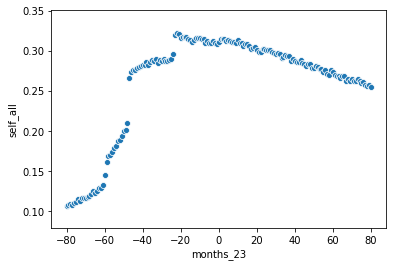

In [29]:
sns.scatterplot(x='months_23', y='self_all', data=ed_df)

## Sk-learn background function

In [30]:
iterations = 40
# Herlands use poly=3: how to choose this???
X_aug = ed_df['months_23'].values.reshape(-1, 1) ** np.arange(4)
print(ed_df.shape)
print(X_aug.shape)
reg = LinearRegression()
X = ed_df.drop('Ts', axis='columns')
reg.fit(X_aug, ed_df['Ts'])

(161, 225)
(161, 4)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
ed_df['Ps'] = reg.predict(X_aug)

Text(0.5, 1.0, 'running vs predicted probability, sklearn LR')

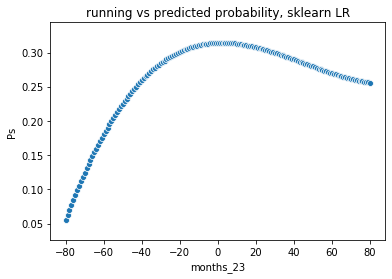

In [32]:
sns.scatterplot(x=ed_df['months_23'], y=ed_df['Ps'])
plt.title("running vs predicted probability, sklearn LR")

### Build tree

In [33]:
%%time
tree = RDDTree(df = ed_df[['months_23', 'Ps', 'Ts']], 
               max_depth = 4, 
               min_size = 2, 
               threshold = -1)
tree.build_tree()

candidate column: months_23
split at level 0
candidate column: months_23
split at level 1
candidate column: months_23
split at level 2
candidate column: months_23
split at level 1
candidate column: months_23
split at level 2
candidate column: months_23
split at level 3
candidate column: months_23
split at level 4
candidate column: months_23
split at level 3
candidate column: months_23
split at level 4
candidate column: months_23
split at level 4
candidate column: months_23
split at level 2
candidate column: months_23
split at level 3
candidate column: months_23
split at level 4
candidate column: months_23
split at level 4
candidate column: months_23
split at level 3
candidate column: months_23
split at level 4
candidate column: months_23
split at level 4
CPU times: user 22.4 s, sys: 295 ms, total: 22.7 s
Wall time: 21.4 s


In [34]:
print("Root: " + str(tree.root))
print("\tRight: " + str(tree.root.right))
print("\t\tLeft: " + str(tree.root.right.left))
print("\t\tRight: " + str(tree.root.right.right))
print("\t\t\tRight: " + str(tree.root.right.right.right))

Root: Split col: months_23, val: -76, llr: 0.048534353417384275
	Right: Split col: months_23, val: -48, llr: 0.04539862255374358
		Left: Split col: months_23, val: -71, llr: 0.016626857089703358
		Right: Split col: months_23, val: -35, llr: 0.01655798085986937
			Right: Split col: months_23, val: -9, llr: 0.003790551246721577


## Herlands background function

In [35]:
fx = smd.Logit(endog=np.array(ed_df['Ts']), exog=np.array(X_aug)).fit()
fitted_vals = fx.predict(X_aug)

Optimization terminated successfully.
         Current function value: 0.467061
         Iterations 6


Text(0.5, 1.0, 'running vs predicted probability, statsmodel logit')

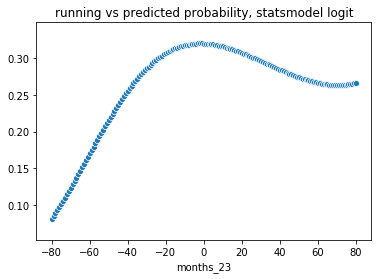

In [36]:
sns.scatterplot(x=ed_df['months_23'], y=fitted_vals)
plt.title("running vs predicted probability, statsmodel logit")

In [37]:
ed_df['Ps'] = fitted_vals

In [38]:
%%time
tree = RDDTree(df = ed_df[['months_23', 'Ps', 'Ts']], 
               max_depth = 4, 
               min_size = 2, 
               threshold = -1)
tree.build_tree()

candidate column: months_23
split at level 0
candidate column: months_23
split at level 1
candidate column: months_23
split at level 2
candidate column: months_23
split at level 3
candidate column: months_23
split at level 3
candidate column: months_23
split at level 4
candidate column: months_23
split at level 2
candidate column: months_23
split at level 3
candidate column: months_23
split at level 4
candidate column: months_23
split at level 4
candidate column: months_23
split at level 3
candidate column: months_23
split at level 4
candidate column: months_23
split at level 1
candidate column: months_23
split at level 2
candidate column: months_23
split at level 3
candidate column: months_23
split at level 4
candidate column: months_23
split at level 4
candidate column: months_23
split at level 3
candidate column: months_23
split at level 4
candidate column: months_23
split at level 4
candidate column: months_23
split at level 2
candidate column: months_23
split at level 3
candidate 

In [39]:
print("Root: " + str(tree.root))
print("\tRight: " + str(tree.root.right))
print("\t\tLeft: " + str(tree.root.right.left))
print("\t\tRight: " + str(tree.root.right.right))
print("\t\t\tRight: " + str(tree.root.right.right.right))

Root: Split col: months_23, val: -48, llr: 0.01260546094692515
	Right: Split col: months_23, val: -35, llr: 0.02529739572359685
		Left: Split col: months_23, val: -41, llr: 0.0021138005149592964
		Right: Split col: months_23, val: -16, llr: 0.001453249896196464
			Right: Split col: months_23, val: 22, llr: 0.0031929976018849173
